## Patrick's "Battle of the Neighborhoods" Coursera Capstone Project Notebook!

### Problem Set:
    Comparing neighborhoods in the cities of Cincinnati and Dayton Ohio
    

### Criteria: 
we are going to look at the number of nearby breweries and coffe shops as well as the average home cost to make a decision about the most fun, but affordable neighborhoods/city to live in.

### Use case: 
This type of analysis would be useful for home buyers looking for the best neighborhood to live in, or for investors looking for the best neighborhood to invest in (or where the market is saturated).

### Data:
The data used in this notebook is a table of city neighborhood data and locations with Zillow real estate average home cost added.
This data will be combined with a venue category search (brewery and coffee shop) to get three data points per neighborhood to complete the cluster analysis on.

Why brewery and Coffee shop? ...clusters of these buisnesses tend to open in trendy upcomming neighborhoods where real estate values are still cheap, but young professionals are congregating.

...

#### Prepare the environment by importing all necessary modules

In [295]:
import pandas as pd
import numpy as np
import json                                # library to handle JSON files
from geopy.geocoders import Nominatim      # convert an address into latitude and longitude values
import requests                            # library to handle requests
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm                 # Matplotlib and associated plotting modules
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans         # import k-means from clustering stage
import folium
from bs4 import BeautifulSoup              # Import BeautifulSoup package to parse wiki website
import geocoder
import fastkml
from fastkml import  kml
import quandl                              # Setup API for neighborhood housing data
quandl.ApiConfig.api_key = "wYmDtm_wythZw4HbXAKr"

...

## Part 1: Data Wrangling - Gather City / Neighborhood Information

#### Read in the Dayton, OH Neighborhood Data with Latitude, Longitude data as well as real estate sales information from Zillow

In [296]:
filename="Dayton_hoods2.csv"
Dayton_data=pd.read_csv(filename)
print(Dayton_data.shape)
Dayton_data.head(10)

(62, 7)


,Latitude,Longitude,Neighborhood,City,State,County,Home Value
0,39.747656,-84.245002,Arlington Heights,Dayton,OH,Montgomery,30823
1,39.709226,-84.063269,Beavercreek,Dayton,OH,Greene,217489
2,39.733461,-84.140875,Belmont,Dayton,OH,Montgomery,87032
3,39.759672,-84.151428,Burkhardt,Dayton,OH,Montgomery,61238
4,39.741796,-84.200474,Carillon,Dayton,OH,Montgomery,31161
5,39.783338,-84.239734,College Hill,Dayton,OH,Montgomery,49168
6,39.773070,-84.239734,Cornell Heights,Dayton,OH,Montgomery,34983
7,39.780248,-84.229197,Dayton View Triangle,Dayton,OH,Montgomery,69062
8,39.797985,-84.198892,DeWeese,Dayton,OH,Montgomery,85244
9,39.760571,-84.194938,Downtown,Dayton,OH,Montgomery,169512


#### Now, Read in the Cincinnati, OH Neighborhood Data with Latitude, Longitude data as real estate sales information from Zillow

In [297]:
filename="Cincinnati_hoods2.csv"
Cincinnati_data=pd.read_csv(filename)
print(Cincinnati_data.shape)
Cincinnati_data.head(10)

(62, 7)


,Neighborhood,Latitude,Longitude,City,State,County,House Value
0,Avondale,39.144963,-84.497811,Cincinnati,OH,Hamilton,81719
1,Bond Hill,39.177785,-84.477659,Cincinnati,OH,Hamilton,111614
2,California,39.065338,-84.419893,Cincinnati,OH,Hamilton,128577
3,Camp Washington,39.137950,-84.537609,Cincinnati,OH,Hamilton,58310
4,Carthage,39.195869,-84.485014,Cincinnati,OH,Hamilton,68406
5,Clifton Heights,39.125934,-84.520908,Cincinnati,OH,Hamilton,298535
6,College Hill,39.198536,-84.548428,Cincinnati,OH,Hamilton,130138
7,Columbia-Tusculum,39.115193,-84.436140,Cincinnati,OH,Hamilton,325009
8,Corryville,39.136807,-84.503866,Cincinnati,OH,Hamilton,158269
9,CUF,39.125115,-84.525842,Cincinnati,OH,Hamilton,161286


### Now, with the neighborhood data, we can visualize it on a map using folium 

In [298]:
address = 'Dayton, OH'

geolocator = Nominatim(user_agent="OH_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Dayton, OH are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Dayton, OH are 39.7589478, -84.1916069.


In [299]:
# create map ofDayton, OH using latitude and longitude values
map_Dayton = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(Dayton_data['Latitude'], Dayton_data['Longitude'], Dayton_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Dayton)  
    
map_Dayton

In [300]:
address = 'Cincinnati, OH'

geolocator = Nominatim(user_agent="OH_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Cincinnati, OH are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Cincinnati, OH are 39.1014537, -84.5124602.


In [301]:
# create map ofCincinnati, OH using latitude and longitude values
map_Cincinnati = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(Cincinnati_data['Latitude'], Cincinnati_data['Longitude'], Cincinnati_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Cincinnati)  
    
map_Cincinnati

## Now Use FourSquare to Gather Venue Data for the Two Cities
### "Trendy" Venues Chosen for focus: Breweries and Coffee Shops

#### Set up FourSquare Client information

In [53]:
CLIENT_ID = 'G4XYV2OWUJSPBPVI00SJXGVWFAP21E3ZNJXHWTSAODQPKIVG' # your Foursquare ID
CLIENT_SECRET = 'J3TXUHL4AZBXEYYRU2OF4OW33BXUR1KKSCMWHLJOKYQUJK2I' # your Foursquare Secret
#VERSION = '20180605' # Foursquare API version
VERSION = '20200101' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: G4XYV2OWUJSPBPVI00SJXGVWFAP21E3ZNJXHWTSAODQPKIVG
CLIENT_SECRET:J3TXUHL4AZBXEYYRU2OF4OW33BXUR1KKSCMWHLJOKYQUJK2I


In [302]:
# Find Brewery Venue Locations in Dayton Ohio
Dayton_venues = getNearbyVenues(names=Dayton_data['Neighborhood'],
                                   latitudes=Dayton_data['Latitude'],
                                   longitudes=Dayton_data['Longitude']
                                  )

In [303]:
# Find Coffee Shop Venue Locations in Dayton Ohio
Dayton_venues2 = getNearbyVenues2(names=Dayton_data['Neighborhood'],
                                   latitudes=Dayton_data['Latitude'],
                                   longitudes=Dayton_data['Longitude']
                                  )

In [304]:
# Find Brewery Venue Locations in Cincinnati Ohio
Cincinnati_venues = getNearbyVenues(names=Cincinnati_data['Neighborhood'],
                                   latitudes=Cincinnati_data['Latitude'],
                                   longitudes=Cincinnati_data['Longitude']
                                  )

In [305]:
# Find Coffee Shop Venue Locations in Cincinnati Ohio
Cincinnati_venues2 = getNearbyVenues2(names=Cincinnati_data['Neighborhood'],
                                   latitudes=Cincinnati_data['Latitude'],
                                   longitudes=Cincinnati_data['Longitude']
                                  )

#### Look at the size of the resulting venue outputs

In [306]:
print('Dayton Brew Shape:',Dayton_venues.shape)
print('Dayton Coffee Shape:',Dayton_venues.shape)
print('Cincinnati Brew Shape:',Cincinnati_venues.shape)
print('Cincinnati Coffee Shape:',Cincinnati_venues.shape)

Dayton Brew Shape: (69, 7)
Dayton Coffee Shape: (69, 7)
Cincinnati Brew Shape: (184, 7)
Cincinnati Coffee Shape: (184, 7)


### The FourSquare Search returned "Cafes" as well as "Coffee shops". I want to focus on Coffeeshops in particular so I drop the rows with "cafe".   Similarly, Drop "bar" and "Pub" from the Brewery Category.

In [307]:
Dayton_venues2.drop(Dayton_venues2[ Dayton_venues2['Coffeeshop Category'] == 'Café' ].index , inplace=True)
Cincinnati_venues2.drop(Cincinnati_venues2[Cincinnati_venues2['Coffeeshop Category'] == 'Café' ].index , inplace=True)
Cincinnati_venues.drop(Cincinnati_venues[Cincinnati_venues['Brewery Category'] == 'Bar' ].index , inplace=True)
Cincinnati_venues.drop(Cincinnati_venues[Cincinnati_venues['Brewery Category'] == 'Pub' ].index , inplace=True)

In [308]:
Dayton_venues.to_csv(r'Dayton_brews.csv', index = False, header=True)
Dayton_venues2.to_csv(r'Dayton_coffee.csv', index = False, header=True)
Cincinnati_venues.to_csv(r'Cincy_brews.csv', index = False, header=True)
Cincinnati_venues2.to_csv(r'Cincy_coffee.csv', index = False, header=True)


 ### Now, group each search by "Neighborhood" and count of Brewery / Coffeeshop

In [309]:
# For Dayton
Dayton_Coffee = Dayton_venues2.groupby('Neighborhood').count()  # Provide a count of Coffeeshops per neighborhood
Dayton_Brew = Dayton_venues.groupby('Neighborhood').count()     # Provide a count of Breweries per neighborhood
# For Cincinnati
Cincinnati_Coffee = Cincinnati_venues2.groupby('Neighborhood').count()  # Provide a count of Coffeeshops per neighborhood
Cincinnati_Brew = Cincinnati_venues.groupby('Neighborhood').count()     # Provide a count of Breweries per neighborhood

### Now merge all the search results back together, first for Dayton, the repeat for Cincinnati

In [310]:
Dayton_Brew2=Dayton_Brew[['Brewery']]
Dayton_Brew2 = Dayton_Brew2.reset_index()

Dayton_Coffee2=Dayton_Coffee[['Coffeeshop']]
Dayton_Coffee2 = Dayton_Coffee2.reset_index()

Dayton_merged = Dayton_Brew2.join(Dayton_Coffee2.set_index('Neighborhood'), on='Neighborhood')
Dayton_merged =Dayton_merged.fillna(0)
Dayton_merged =Dayton_merged.astype({'Coffeeshop': 'int32'})
print(Dayton_merged.shape)
Dayton_merged.head()

(31, 3)


,Neighborhood,Brewery,Coffeeshop
0,Belmont,3,4
1,Burkhardt,1,1
2,Carillon,1,1
3,College Hill,1,0
4,Cornell Heights,1,0


In [311]:
#pd.set_option('display.max_rows', None)
Dayton_all = Dayton_data.join(Dayton_merged.set_index('Neighborhood'), on='Neighborhood')
Dayton_all =Dayton_all.fillna('0')
print(Dayton_all.shape)
Dayton_all.head()


(62, 9)


,Latitude,Longitude,Neighborhood,City,State,County,Home Value,Brewery,Coffeeshop
0,39.747656,-84.245002,Arlington Heights,Dayton,OH,Montgomery,30823,0,0
1,39.709226,-84.063269,Beavercreek,Dayton,OH,Greene,217489,0,0
2,39.733461,-84.140875,Belmont,Dayton,OH,Montgomery,87032,3,4
3,39.759672,-84.151428,Burkhardt,Dayton,OH,Montgomery,61238,1,1
4,39.741796,-84.200474,Carillon,Dayton,OH,Montgomery,31161,1,1


### Add in a "normalized" column for home value for the clustering step

In [312]:
Dayton_all['HV_Norm']=Dayton_all['Home Value']/100000
Dayton_all.head()

,Latitude,Longitude,Neighborhood,City,State,County,Home Value,Brewery,Coffeeshop,HV_Norm
0,39.747656,-84.245002,Arlington Heights,Dayton,OH,Montgomery,30823,0,0,0.30823
1,39.709226,-84.063269,Beavercreek,Dayton,OH,Greene,217489,0,0,2.17489
2,39.733461,-84.140875,Belmont,Dayton,OH,Montgomery,87032,3,4,0.87032
3,39.759672,-84.151428,Burkhardt,Dayton,OH,Montgomery,61238,1,1,0.61238
4,39.741796,-84.200474,Carillon,Dayton,OH,Montgomery,31161,1,1,0.31161


### Now repeat steps for Cincinnati data

In [313]:
Cincinnati_Brew2=Cincinnati_Brew[['Brewery']]
Cincinnati_Brew2 = Cincinnati_Brew2.reset_index()

Cincinnati_Coffee2=Cincinnati_Coffee[['Coffeeshop']]
Cincinnati_Coffee2 = Cincinnati_Coffee2.reset_index()

Cincinnati_merged = Cincinnati_Brew2.join(Cincinnati_Coffee2.set_index('Neighborhood'), on='Neighborhood')
Cincinnati_merged =Cincinnati_merged.fillna(0)
Cincinnati_merged =Cincinnati_merged.astype({'Coffeeshop': 'int64'})
print(Cincinnati_merged.shape)
Cincinnati_merged.head()

(47, 3)


,Neighborhood,Brewery,Coffeeshop
0,Amberley,2,0
1,Bridgetown North,3,0
2,CUF,8,3
3,California,1,0
4,Camp Washington,2,2


In [314]:
pd.set_option('display.max_rows', None)
Cincinnati_all = Cincinnati_data.join(Cincinnati_merged.set_index('Neighborhood'), on='Neighborhood')
Cincinnati_all =Cincinnati_all.fillna('0')
print(Cincinnati_all.shape)
Cincinnati_all.head()

(62, 9)


,Neighborhood,Latitude,Longitude,City,State,County,House Value,Brewery,Coffeeshop
0,Avondale,39.144963,-84.497811,Cincinnati,OH,Hamilton,81719,0,0
1,Bond Hill,39.177785,-84.477659,Cincinnati,OH,Hamilton,111614,0,0
2,California,39.065338,-84.419893,Cincinnati,OH,Hamilton,128577,1,0
3,Camp Washington,39.137950,-84.537609,Cincinnati,OH,Hamilton,58310,2,2
4,Carthage,39.195869,-84.485014,Cincinnati,OH,Hamilton,68406,0,0


In [318]:
Cincinnati_all['HV_Norm']=Cincinnati_all['Home Value']/100000
Cincinnati_all=Cincinnati_all.rename(columns={"House Value": "Home Value"})
Cincinnati_all.head()

,Neighborhood,Latitude,Longitude,City,State,County,Home Value,Brewery,Coffeeshop,HV_Norm
0,Avondale,39.144963,-84.497811,Cincinnati,OH,Hamilton,81719,0,0,0.81719
1,Bond Hill,39.177785,-84.477659,Cincinnati,OH,Hamilton,111614,0,0,1.11614
2,California,39.065338,-84.419893,Cincinnati,OH,Hamilton,128577,1,0,1.28577
3,Camp Washington,39.137950,-84.537609,Cincinnati,OH,Hamilton,58310,2,2,0.58310
4,Carthage,39.195869,-84.485014,Cincinnati,OH,Hamilton,68406,0,0,0.68406


## Exploratory Data Analysis

In [320]:
print(Dayton_all.shape)
print(Cincinnati_all.shape)
Merged=Dayton_all.append(Cincinnati_all)
print(Merged.shape) 

(62, 10)
(62, 10)
(124, 10)


In [321]:
mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.1


### Plot histograms for the Home Value Column for Dayton and Cincinnati samples for comparison
#### The resulting plots show clear differences in the real estate values between Cincinnati and Dayton

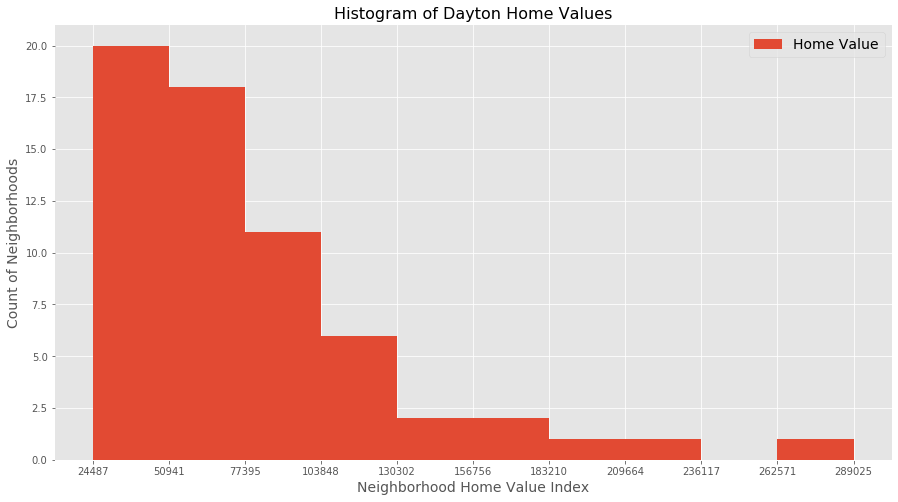

In [322]:
#ax = Merged.plot.bar(x='City', y='Home Value', rot=0)
#plt.show()
count, bin_edges = np.histogram(Dayton_all['Home Value'])


ax = Dayton_all['Home Value'].plot(kind='hist', figsize=(15, 8), xticks=bin_edges)


plt.title('Histogram of Dayton Home Values', fontsize=16)
plt.ylabel('Count of Neighborhoods', fontsize=14)
plt.xlabel('Neighborhood Home Value Index', fontsize=14)

#ax.set_title('Percentage of Respondants interested in Data Science Areas', fontsize=16)
ax.legend(prop=dict(size=14))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.yaxis.set_visible(False)


plt.show()

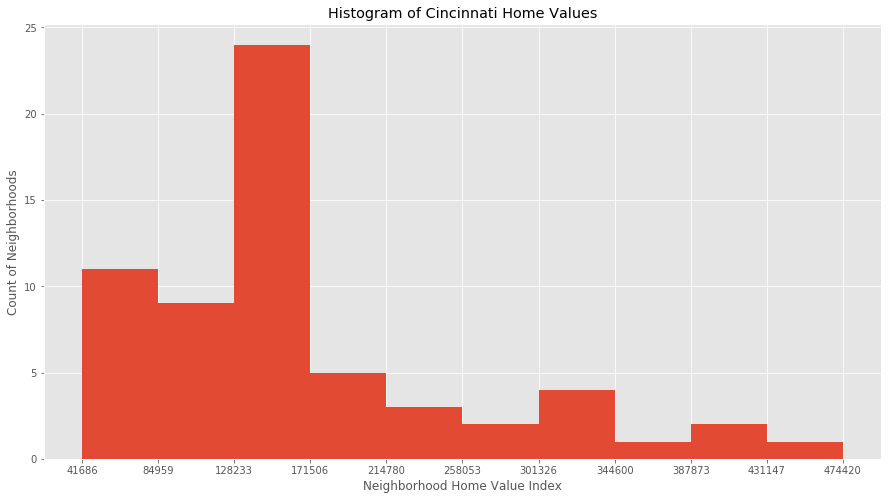

In [323]:
count, bin_edges = np.histogram(Cincinnati_all['Home Value'])

Cincinnati_all['Home Value'].plot(kind='hist', figsize=(15, 8), xticks=bin_edges)

plt.title('Histogram of Cincinnati Home Values')
plt.ylabel('Count of Neighborhoods')
plt.xlabel('Neighborhood Home Value Index')

plt.show()

## Part 2: Clustering Analysis with kmeans

...

#### Now that we have properly cleaned and arranged data and we got our initial impressions of it through EDA, it is time to explore how these neighborhoods might cluster together.

#### The number of clusters needs to be determined, we run the process for 3, 4, and 5 clusters

In [325]:
# set number of clusters as 3 
kclusters = 3
Merged_clustering = Merged.drop({'Neighborhood','City','County','Home Value','Latitude','Longitude','State'}, 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Merged_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 0])

In [326]:
# set number of clusters as 4
kclusters2 = 4
Merged_clustering2 = Merged.drop({'Neighborhood','City','County','Home Value','Latitude','Longitude','State'}, 1)

# run k-means clustering
kmeans2 = KMeans(n_clusters=kclusters2, random_state=0).fit(Merged_clustering2)

# check cluster labels generated for each row in the dataframe
kmeans2.labels_[0:10] 

array([3, 3, 0, 3, 3, 3, 3, 3, 3, 2])

In [327]:
# set number of clusters as 5
kclusters3 = 5
Merged_clustering3 = Merged.drop({'Neighborhood','City','County','Home Value','Latitude','Longitude','State'}, 1)

# run k-means clustering
kmeans3 = KMeans(n_clusters=kclusters3, random_state=0).fit(Merged_clustering3)

# check cluster labels generated for each row in the dataframe
kmeans3.labels_[0:10] 

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 0])

#### Make a copy of the full data, and merge each cluster itteration into its own copy.

In [331]:
Merged2=Merged.copy()
Merged2 = Merged.drop('Cluster Labels', 1)
Merged3=Merged2.copy()
Merged3.head()

,Brewery,City,Coffeeshop,County,HV_Norm,Home Value,Latitude,Longitude,Neighborhood,State
0,0,Dayton,0,Montgomery,0.30823,30823,39.747656,-84.245002,Arlington Heights,OH
1,0,Dayton,0,Greene,2.17489,217489,39.709226,-84.063269,Beavercreek,OH
2,3,Dayton,4,Montgomery,0.87032,87032,39.733461,-84.140875,Belmont,OH
3,1,Dayton,1,Montgomery,0.61238,61238,39.759672,-84.151428,Burkhardt,OH
4,1,Dayton,1,Montgomery,0.31161,31161,39.741796,-84.200474,Carillon,OH


In [338]:
# add clustering labels
Merged.insert(0, 'Cluster Labels', kmeans.labels_)
Merged
Merged2.insert(0, 'Cluster Labels', kmeans2.labels_)
Merged2
Merged3.insert(0, 'Cluster Labels', kmeans3.labels_)
Merged3.head()

,Cluster Labels,Brewery,City,Coffeeshop,County,HV_Norm,Home Value,Latitude,Longitude,Neighborhood,State
0,1,0,Dayton,0,Montgomery,0.30823,30823,39.747656,-84.245002,Arlington Heights,OH
1,1,0,Dayton,0,Greene,2.17489,217489,39.709226,-84.063269,Beavercreek,OH
2,0,3,Dayton,4,Montgomery,0.87032,87032,39.733461,-84.140875,Belmont,OH
3,1,1,Dayton,1,Montgomery,0.61238,61238,39.759672,-84.151428,Burkhardt,OH
4,1,1,Dayton,1,Montgomery,0.31161,31161,39.741796,-84.200474,Carillon,OH


# View the cluster results

### Folium maps were used to view the results of the kmeans clustering. The code was run for each number of cluster values and the results explored. The k-cluster level = 5 provided the best results.

#### First, we get the coordinates for Middletown Ohio, so our map is centered between Cincinnati and Dayton

In [332]:
address = 'middletown, OH'

geolocator = Nominatim(user_agent="OH_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Middletown, OH are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Middletown, OH are 39.5150576, -84.3982763.


In [339]:
# create map for the "5 Clusters" case
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters3)
ys = [i + x + (i*x)**2 for i in range(kclusters3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Merged3['Latitude'], Merged3['Longitude'], Merged3['Neighborhood'], Merged3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Now we will look at each cluster in more detail, using the df.describe() method to see what the clusters have in common.

In [340]:
Merged3 =Merged3.astype({'Brewery': 'int64'})
Merged3 =Merged3.astype({'Coffeeshop': 'int64'})
Merged3['Sum']=Merged3['Brewery']+Merged3['Coffeeshop']

#### Isolate off copies of each cluster for more comparrisons

In [284]:
M0=Merged3.loc[Merged3['Cluster Labels'] == 0]
M1=Merged3.loc[Merged3['Cluster Labels'] == 1]
M2=Merged3.loc[Merged3['Cluster Labels'] == 2]
M3=Merged3.loc[Merged3['Cluster Labels'] == 3]
M4=Merged3.loc[Merged3['Cluster Labels'] == 4]

In [285]:
M0.describe()   # Cluster 0

,Cluster Labels,Brewery,Coffeeshop,HV_Norm,Home Value,Latitude,Longitude,Sum
count,72.0,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,0.0,0.361111,0.083333,0.908646,90864.555556,39.550048,-84.316274,0.444444
std,0.0,0.483693,0.325014,0.636138,63613.762767,0.299277,0.169227,0.669010
min,0.0,0.000000,0.000000,0.244870,24487.000000,39.065338,-84.687136,0.000000
25%,0.0,0.000000,0.000000,0.536800,53680.000000,39.184958,-84.479497,0.000000
50%,0.0,0.000000,0.000000,0.680560,68056.000000,39.743145,-84.241709,0.000000
75%,0.0,1.000000,0.000000,1.188550,118855.000000,39.774734,-84.209435,1.000000
max,0.0,1.000000,2.000000,3.909700,390970.000000,39.824165,-84.019379,3.000000


In [286]:
M1.describe()   # Cluster 1

,Cluster Labels,Brewery,Coffeeshop,HV_Norm,Home Value,Latitude,Longitude,Sum
count,3.0,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,1.0,11.333333,14.666667,3.039567,303956.666667,39.107582,-84.513659,26.0
std,0.0,1.154701,2.081666,0.436028,43602.829430,0.007161,0.004518,1.0
min,1.0,10.000000,13.000000,2.576910,257691.000000,39.099435,-84.516573,25.0
25%,1.0,11.000000,13.500000,2.837905,283790.500000,39.104931,-84.516261,25.5
50%,1.0,12.000000,14.000000,3.098900,309890.000000,39.110427,-84.515948,26.0
75%,1.0,12.000000,15.500000,3.270895,327089.500000,39.111655,-84.512201,26.5
max,1.0,12.000000,17.000000,3.442890,344289.000000,39.112883,-84.508455,27.0


In [287]:
M2.describe()   # Cluster 2

,Cluster Labels,Brewery,Coffeeshop,HV_Norm,Home Value,Latitude,Longitude,Sum
count,29.0,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,2.0,2.931034,0.965517,1.617658,161765.793103,39.338703,-84.390524,3.896552
std,0.0,1.131719,0.731083,1.015362,101536.155239,0.280007,0.158712,1.496301
min,2.0,2.000000,0.000000,0.286260,28626.000000,39.099035,-84.632216,2.000000
25%,2.0,2.000000,0.000000,0.954330,95433.000000,39.142362,-84.513775,3.000000
50%,2.0,3.000000,1.000000,1.545130,154513.000000,39.164480,-84.427997,3.000000
75%,2.0,4.000000,1.000000,2.013400,201340.000000,39.725337,-84.200210,5.000000
max,2.0,6.000000,2.000000,4.744200,474420.000000,39.773670,-84.158023,7.000000


In [288]:
M3.describe()   # Cluster 3

,Cluster Labels,Brewery,Coffeeshop,HV_Norm,Home Value,Latitude,Longitude,Sum
count,7.0,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,3.0,10.142857,4.000000,2.041820,204182.000000,39.117401,-84.515850,14.142857
std,0.0,1.772811,1.914854,1.174867,117486.736636,0.006763,0.012433,3.132016
min,3.0,8.000000,1.000000,0.511280,51128.000000,39.109160,-84.527496,10.000000
25%,3.0,8.500000,3.000000,1.624805,162480.500000,39.112388,-84.525948,11.500000
50%,3.0,11.000000,4.000000,1.636750,163675.000000,39.115338,-84.520908,15.000000
75%,3.0,11.500000,5.000000,2.371200,237120.000000,39.123301,-84.507721,16.500000
max,3.0,12.000000,7.000000,4.152700,415270.000000,39.125934,-84.495205,18.000000


In [289]:
M4.describe()   # Cluster 4

,Cluster Labels,Brewery,Coffeeshop,HV_Norm,Home Value,Latitude,Longitude,Sum
count,13.0,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,4.0,2.846154,4.384615,1.430357,143035.692308,39.422245,-84.347074,7.230769
std,0.0,1.675617,1.502135,0.627331,62733.138814,0.316549,0.161078,2.803386
min,4.0,1.000000,3.000000,0.612380,61238.000000,39.105337,-84.551610,4.000000
25%,4.0,2.000000,3.000000,1.003160,100316.000000,39.136807,-84.477637,5.000000
50%,4.0,2.000000,4.000000,1.582690,158269.000000,39.181768,-84.428286,6.000000
75%,4.0,4.000000,5.000000,1.695120,169512.000000,39.749641,-84.194938,8.000000
max,4.0,6.000000,7.000000,2.806860,280686.000000,39.767755,-84.140875,13.000000


### Now Plot the Clusters together to visibly see how they grouped

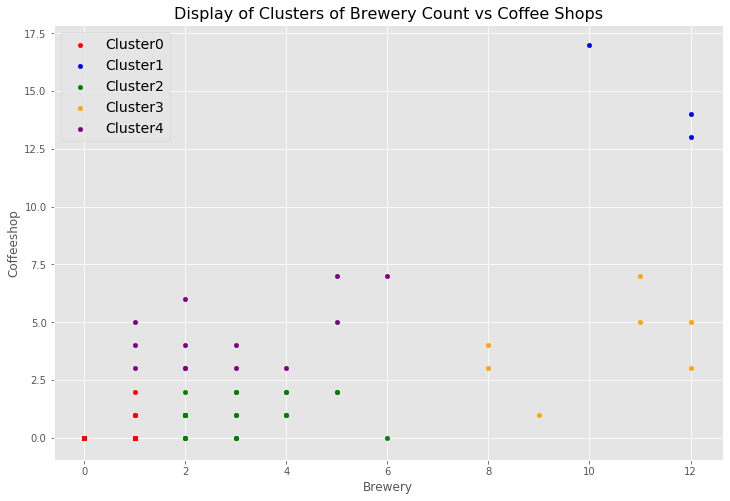

In [290]:
ax = M0.plot(kind='scatter', x='Brewery', y='Coffeeshop',
                                           color='Red', label='Cluster0', figsize=(12, 8))
M1.plot(kind='scatter', x='Brewery', y='Coffeeshop',
                                           color='Blue', label='Cluster1', ax=ax)
M2.plot(kind='scatter', x='Brewery', y='Coffeeshop',
                                           color='Green', label='Cluster2', ax=ax)
M3.plot(kind='scatter', x='Brewery', y='Coffeeshop',
                                           color='Orange', label='Cluster3', ax=ax)
M4.plot(kind='scatter', x='Brewery', y='Coffeeshop',
                                           color='Purple', label='Cluster4', ax=ax)

plt.title('Display of Clusters of Brewery Count vs Coffee Shops', fontsize=16)
ax.legend(prop=dict(size=14))


plt.show()

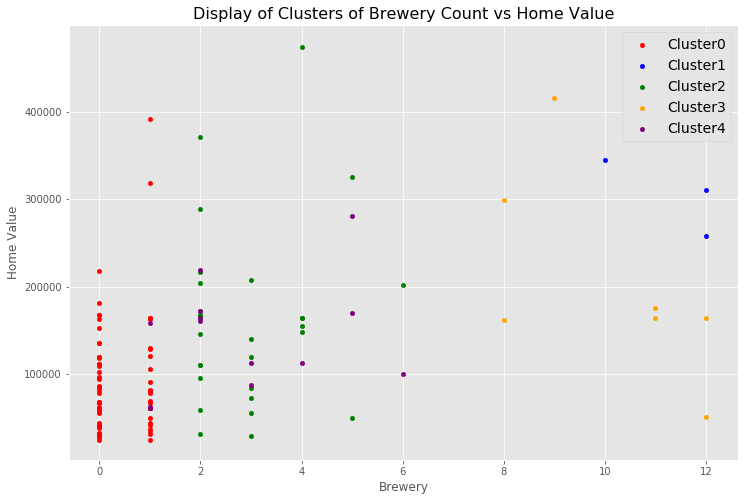

In [282]:
ax = M0.plot(kind='scatter', x='Brewery', y='Home Value',
                                           color='Red', label='Cluster0', figsize=(12, 8))
M1.plot(kind='scatter', x='Brewery', y='Home Value',
                                           color='Blue', label='Cluster1', ax=ax)
M2.plot(kind='scatter', x='Brewery', y='Home Value',
                                           color='Green', label='Cluster2', ax=ax)
M3.plot(kind='scatter', x='Brewery', y='Home Value',
                                           color='Orange', label='Cluster3', ax=ax)
M4.plot(kind='scatter', x='Brewery', y='Home Value',
                                           color='Purple', label='Cluster4', ax=ax)

plt.title('Display of Clusters of Brewery Count vs Home Value', fontsize=16)
ax.legend(prop=dict(size=14))


plt.show()

### For this final plot, the count of Brewery and coffeeshop are summed together and plotted vs Home value to get a better feel for how they combine in the clustering.

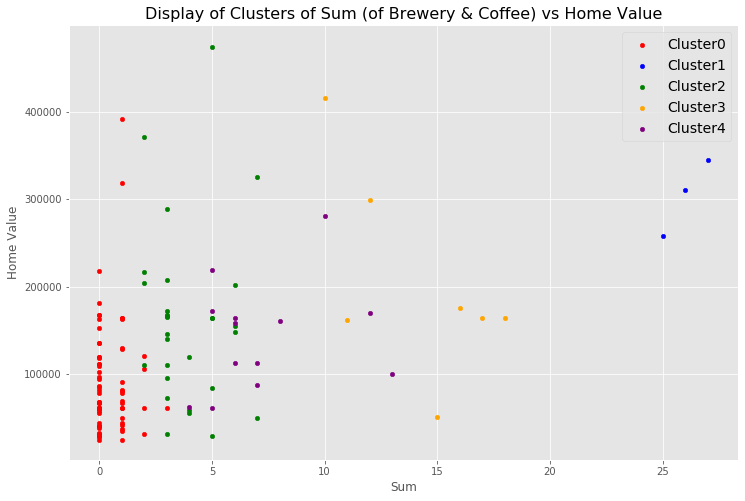

In [291]:
ax = M0.plot(kind='scatter', x='Sum', y='Home Value',
                                           color='Red', label='Cluster0', figsize=(12, 8))
M1.plot(kind='scatter', x='Sum', y='Home Value',
                                           color='Blue', label='Cluster1', ax=ax)
M2.plot(kind='scatter', x='Sum', y='Home Value',
                                           color='Green', label='Cluster2', ax=ax)
M3.plot(kind='scatter', x='Sum', y='Home Value',
                                           color='Orange', label='Cluster3', ax=ax)
M4.plot(kind='scatter', x='Sum', y='Home Value',
                                           color='Purple', label='Cluster4', ax=ax)

plt.title('Display of Clusters of Sum (of Brewery & Coffee) vs Home Value', fontsize=16)
ax.legend(prop=dict(size=14))


plt.show()

# Conclusions:

#### The neighborhood discovery, analysis, and clustering project provided interesting and useable results for identifying groups of similar neighborhoods in two different cities. 

#### Cluster 0: is comprised of the lower price-range, low-venue count neighborhoods. These are the least desirable neighborhoods in this project.

#### Cluster 1: is comprised of the very high price-range,venue-dense neighborhoods. While these neighborhoods are certainly the top of the market, the housing cost puts them out of most modest budgets and the density of venues suggest there may be little room to expand the market. An additional issue, is that this cluster is solely in Cincinnati, which limits its usefulness if you are looking in Dayton.

#### Cluster 2: this cluster starts to get after the desired results, of affordability and venue density, but is still on the low-end of both, but it does look to overlap a bit with cluster 4.

#### Cluster 3: is the opposite of cluster 2, this cluster starts to get on the high-end of affordability and venue count, again with a bit of overlap with cluster 4.

#### Cluster 4: is the sweet spot in this analysis. Although a variety of customers might be interested in any of the clusters based on their own circumstances, Cluster 4 provides  balanced levels of both affordability and venue density. This cluster also has decent representation in both cities.

....

# Appendix:

## Definitions Saved at bottom of page to de-clutter the notebook... 

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 1800 # define radius
    venues_list=[]
    query="Brewery"
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}'.format(   
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            query,
            radius
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Brewery', 
                  'Brewery Latitude', 
                  'Brewery Longitude', 
                  'Brewery Category']
    
    return(nearby_venues)

In [15]:
def getNearbyVenues2(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 1000 # define radius
    venues_list=[]
    query="Coffee shop"
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}'.format(   
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            query,
            radius
            )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Coffeeshop', 
                  'Coffeeshop Latitude', 
                  'Coffeeshop Longitude', 
                  'Coffeeshop Category']
    
    return(nearby_venues)